In [4]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [12]:
X = train_data.data

## Part 1: Building the Graph
The first part of Parametric UMAP is shared with non-parametric UMAP, so we can use the same code. First we build a nearest-neighbors graph, using pynndescent, then we build a fuzzy simplicial complex.

In [2]:
from pynndescent import NNDescent
import numpy as np

In [13]:
# number of trees in random projection forest
n_trees = 5 + int(round((X.shape[0]) ** 0.5 / 20.0))
# max number of nearest neighbor iters to perform
n_iters = max(5, int(round(np.log2(X.shape[0]))))
# distance metric
metric="euclidean"
# number of neighbors for computing k-neighbor graph
n_neighbors = 10

# get nearest neighbors
nnd = NNDescent(
    X.reshape((len(X), np.product(np.shape(X)[1:]))),
    n_neighbors=n_neighbors,
    metric=metric,
    n_trees=n_trees,
    n_iters=n_iters,
    max_candidates=60,
    verbose=True
)
# get indices and distances
knn_indices, knn_dists = nnd.neighbor_graph

Fri Nov 25 16:19:19 2022 Building RP forest with 17 trees
Fri Nov 25 16:19:25 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations


In [14]:
# nearest neighbors and distances for each point in the dataset
np.shape(knn_indices), np.shape(knn_dists)

((60000, 10), (60000, 10))

### Build fuzzy simplicial  complex

The `fuzzy_simplicial_set` function takes the nearest neighbor graph and computes a graph of the probabilities of an edge exists between points. 

Local, one-directional, probabilities ($P^{\textrm{UMAP}}_{i|j}$) are computed between a point and its neighbors to determine the probability with which an edge (or simplex exists), based upon an assumption that data is uniformly distributed across a manifold in a warped dataspace. Under this assumption, a local notion of distance is set by the distance to the $k$\textsuperscript{th} nearest neighbor and the local probability is scaled by that local notion of distance.

$$
p_{j \mid i}^{\textrm{UMAP}} = \exp( -(\textrm{d}( \mathbf{x}_{i},\mathbf{x}_{j}) - \rho_{i}) / \sigma_{i})
$$

Where $\rho_{i}$ is a local connectivity parameter set to the distance from $x_i$ to its nearest neighbor, and $\sigma_{i}$ is a local connectivity parameter set to match the local distance around $x_i$ upon its $k$ nearest neighbors (where $k$ is a hyperparameter). In the UMAP package, these are calculated using `smooth_knn_dist`.

After computing the one-directional edge probabilities for each datapoint, we then compute a global probability as the probability of either of the two local, one-directional, probabilities occurring:

$$
p_{i j}=\left(p_{j \mid i}+p_{i \mid j}\right)-p_{j \mid i} p_{i \mid j}
$$

In [15]:
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set

In [16]:
# get indices and distances
knn_indices, knn_dists = nnd.neighbor_graph
random_state = check_random_state(None)

In [17]:
# build fuzzy_simplicial_set
umap_graph, sigmas, rhos = fuzzy_simplicial_set(
    X = X,
    n_neighbors = n_neighbors,
    metric = metric,
    random_state = random_state,
    knn_indices= knn_indices,
    knn_dists = knn_dists,
)

In [24]:
from torch_geometric.utils import to_scipy_sparse_matrix, to_networkx, from_scipy_sparse_matrix
G = from_scipy_sparse_matrix(umap_graph)

In [63]:
G[0].shape

torch.Size([2, 803462])

In [64]:
G[0]

tensor([[    0,     0,     0,  ..., 59999, 59999, 59999],
        [ 8728, 18932, 24149,  ..., 52171, 57087, 58186]])

(array([ 41200., 165022., 203256.,  99584.,  68654.,  46784.,  31314.,
         22062.,  15892., 109694.]),
 array([3.73e-43, 1.00e-01, 2.00e-01, 3.00e-01, 4.00e-01, 5.00e-01,
        6.00e-01, 7.00e-01, 8.00e-01, 9.00e-01, 1.00e+00], dtype=float32),
 <BarContainer object of 10 artists>)

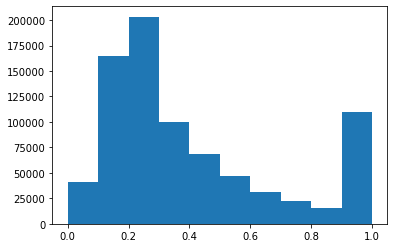

In [39]:
import matplotlib.pyplot as plt
plt.hist(G[1])

## Part 2: Embedding the graph

Now we learn an embedding for the graph, using a neural network. This is where Parametric UMAP differs from non-parametric UMAP. 

### Create neural network model
We first create a neural network to perform the parametric embedding. Here, we'll use a simple convolutional neural network

In [76]:
n_components = 2 # number of latent dimensions
dims = X.shape[0]

In [66]:
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

torch.Size([60000, 28, 28])

In [77]:
dims

60000

In [99]:
import torch.nn as nn
n_components = 2 # number of latent dimensions
dims = X.shape[1:]
class encoder(torch.nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.main = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride = 2),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride = 2),
                torch.nn.ReLU(),
                torch.nn.Flatten(),
                torch.nn.Linear(128, 512),
                torch.nn.ReLU(),
                torch.nn.Linear(512,512),
                torch.nn.ReLU(),
                torch.nn.Linear(512, n_components)
            )

    def forward(self, x):
        out = self.main(x)
        return out

In [ ]:
class CNN(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv1d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv1d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv1d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [104]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = encoder(n_components)
model.to(device)

encoder(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=128, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [108]:
sample = X[0].to(device)

In [106]:
layer=  torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride = 2),
    torch.nn.ReLU(),
)
layer.to(device)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
  (1): ReLU()
)

In [110]:
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
input = torch.randn(20, 16, 50, 100)
output = m(input)